## Project Overview

### Topic
Efficient Reasoning for Generative Candidate Ranking

### Related Works (Baselines)
#### Reasoning for Generative Candidate Ranking
+ [Onerec-Think](https://arxiv.org/html/2510.11639v1) (Kuaishou)
+ [$R^2$ec](https://neurips.cc/virtual/2025/loc/san-diego/poster/117677) (HKUST, Nips 2025)
+ [Generative Reasoning Reranker](http://arxiv.org/abs/2602.07774) (Meta, Close Source)
+ [ThnkRec](https://arxiv.org/abs/2505.15091) (ZJU, WWW26)

#### Implicit Reasoning
+ Baselines in [SemCoT]()
+ [SoftCoT++]()

### Proposed Idea
[Slides Deck](https://nokianam-my.sharepoint.com/:p:/r/personal/zaiyi_zheng_nokia_com/Documents/NokiaPresentation.pptx?d=w1de1f77ec82e40fd81d4b9631edc5311&csf=1&web=1&e=ehhJCR) Page 23-24

## Updates & RoadMap

### Build Codebase for Generative Candidate Ranking (By 2/11/2026)

#### General Pipeline
See [launch.json](.vscode/launch.json)

#### Amazon-Beauty Dataset

Total items: 12101
Fields: ['title', 'description', 'categories', 'sid']

[Item 1]
  title      : Phyto Phytocitrus Restructuring Mask for Unisex, 6.7 Ounce...
  categories : Beauty > Hair Care > Conditioners
  sid        : <|sid_begin|><s_a_99><s_b_19><s_c_220><s_d_204><|sid_end|>
  description: True ColorsPhyto Phytocitrus Restructuring Mask delivers a blend of citrus fruits and proteins that ...

[Item 2]
  title      : Matrix Biolage Colorcaretherapie Color Care Shampoo and Conditioner Set 33.8oz 1...
  categories : Beauty > Hair Care > Shampoo & Conditioner Sets
  sid        : <|sid_begin|><s_a_238><s_b_74><s_c_13><s_d_122><|sid_end|>
  description: Shampoo:
An ultra-mild cleansing Systeme specially formulated to preserve the longevity and radiance...

[Item 3]
  title      : Raw African Black Soap from Ghana 1 Lb...
  categories : Beauty > Bath & Body > Cleansers > Soaps
  sid        : <|sid_begin|><s_a_226><s_b_110><s_c_129><s_d_207><|sid_end|>
  description: Some of the Benefit

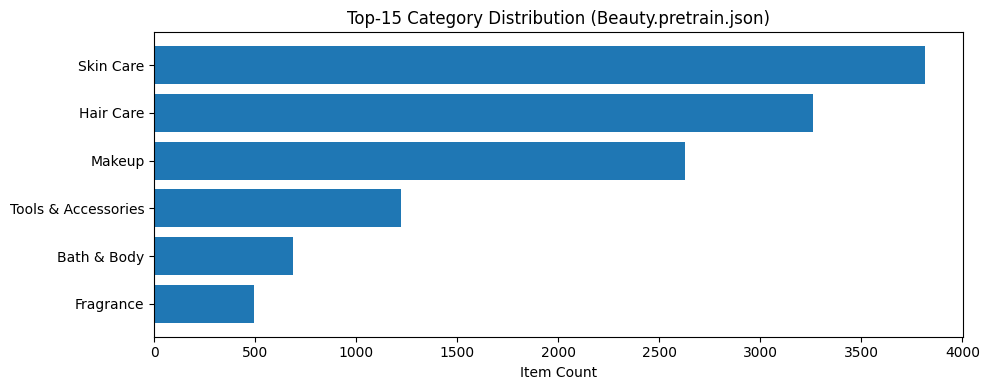

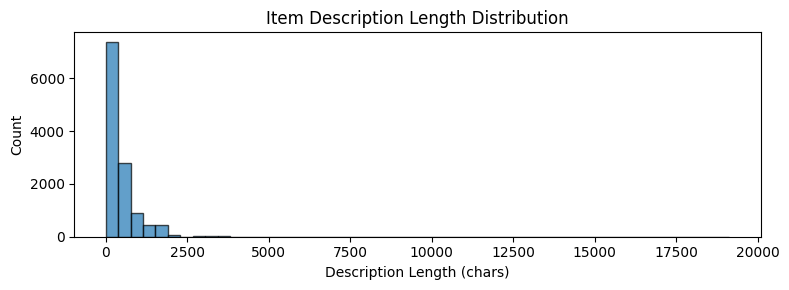

Description length: mean=442, min=0, max=19126


In [ ]:
## ============================================================
## Beauty.pretrain.json — Item metadata catalog
## Each item contains: title, description, categories, sid (Semantic ID)
## sid format: <|sid_begin|><s_a_XX><s_b_XX><s_c_XX><s_d_XX><|sid_end|>
## Purpose: Provides item textual information for Alignment / RA stages
## ============================================================
import json, re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

with open("data/Beauty.pretrain.json", "r", encoding="utf-8") as f:
    items = json.load(f)

print(f"Total items: {len(items)}")
print(f"Fields: {list(next(iter(items.values())).keys())}")
print()

# Show first 3 samples
for k, v in list(items.items())[:3]:
    print(f"[Item {k}]")
    print(f"  title      : {v['title'][:80]}...")
    print(f"  categories : {v['categories']}")
    print(f"  sid        : {v['sid']}")
    print(f"  description: {v['description'][:100]}...")
    print()

# ---- Stats: Top-level category distribution ----
top_cats = [v["categories"].split(" > ")[1] if " > " in v["categories"] else v["categories"]
            for v in items.values() if v.get("categories")]
cat_counts = Counter(top_cats).most_common(15)

fig, ax = plt.subplots(figsize=(10, 4))
ax.barh([c[0] for c in cat_counts][::-1], [c[1] for c in cat_counts][::-1])
ax.set_xlabel("Item Count")
ax.set_title("Top-15 Category Distribution (Beauty.pretrain.json)")
plt.tight_layout()
plt.show()

# ---- Stats: Description length distribution ----
desc_lens = [len(v.get("description", "")) for v in items.values()]
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(desc_lens, bins=50, edgecolor="black", alpha=0.7)
ax.set_xlabel("Description Length (chars)")
ax.set_ylabel("Count")
ax.set_title("Item Description Length Distribution")
plt.tight_layout()
plt.show()

print(f"Description length: mean={sum(desc_lens)/len(desc_lens):.0f}, "
      f"min={min(desc_lens)}, max={max(desc_lens)}")

Total users: 22363
Total interactions: 194687
Sequence length: mean=8.7, median=6, min=5, max=50

First 5 users' interaction sequences:
  User 1: 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 (8 items)
  User 2: 9 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16 -> ... (12 items)
  User 3: 21 -> 22 -> 23 -> 24 -> 25 -> 26 -> 27 -> 28 -> ... (9 items)
  User 4: 30 -> 31 -> 32 -> 33 -> 34 (5 items)
  User 5: 35 -> 36 -> 37 -> 38 -> 39 (5 items)

Unique items (interacted): 12101
Item interaction count: mean=16.1, max=430


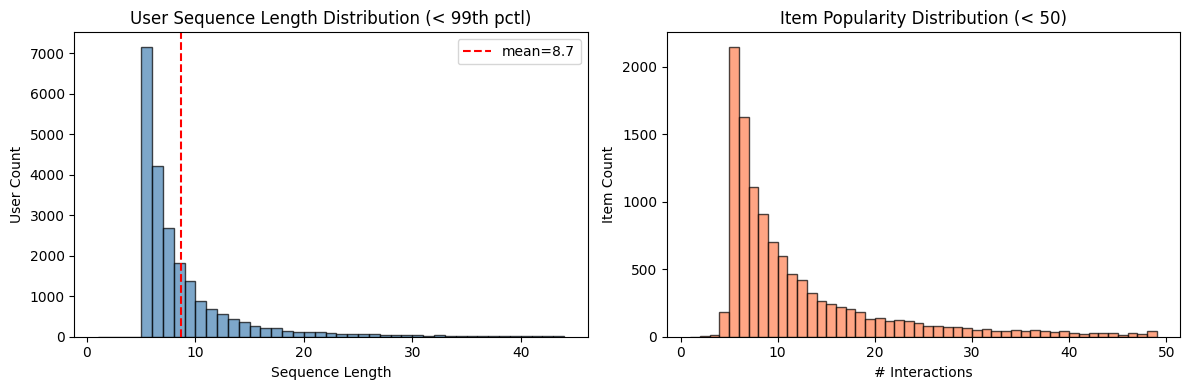

In [ ]:
## ============================================================
## sequential_data_processed.txt — User interaction sequences
## Each line: user_id item_id_1 item_id_2 ... item_id_N
## item_id maps to keys in Beauty.pretrain.json
## Purpose: Source file for all training data; converted to parquet via generate_*.py
## ============================================================

users = []
with open("data/sequential_data_processed.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) > 1:
            users.append({"user_id": parts[0], "item_ids": parts[1:], "seq_len": len(parts) - 1})

df_seq = pd.DataFrame(users)
print(f"Total users: {len(df_seq)}")
print(f"Total interactions: {df_seq['seq_len'].sum()}")
print(f"Sequence length: mean={df_seq['seq_len'].mean():.1f}, median={df_seq['seq_len'].median():.0f}, "
      f"min={df_seq['seq_len'].min()}, max={df_seq['seq_len'].max()}")
print()

# Show first 5 users' sequences
print("First 5 users' interaction sequences:")
for _, row in df_seq.head(5).iterrows():
    ids_str = " -> ".join(row["item_ids"][:8])
    suffix = f" -> ... ({row['seq_len']} items)" if row["seq_len"] > 8 else f" ({row['seq_len']} items)"
    print(f"  User {row['user_id']}: {ids_str}{suffix}")
print()

# ---- Stats: Sequence length distribution ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_seq["seq_len"], bins=range(1, df_seq["seq_len"].quantile(0.99).astype(int) + 2),
             edgecolor="black", alpha=0.7, color="steelblue")
axes[0].set_xlabel("Sequence Length")
axes[0].set_ylabel("User Count")
axes[0].set_title("User Sequence Length Distribution (< 99th pctl)")
axes[0].axvline(df_seq["seq_len"].mean(), color="red", linestyle="--", label=f'mean={df_seq["seq_len"].mean():.1f}')
axes[0].legend()

# ---- Stats: Item interaction frequency distribution ----
all_items = [item for ids in df_seq["item_ids"] for item in ids]
item_freq = Counter(all_items)
freq_vals = list(item_freq.values())
print(f"Unique items (interacted): {len(item_freq)}")
print(f"Item interaction count: mean={sum(freq_vals)/len(freq_vals):.1f}, max={max(freq_vals)}")

axes[1].hist(freq_vals, bins=range(1, min(50, max(freq_vals) + 2)),
             edgecolor="black", alpha=0.7, color="coral")
axes[1].set_xlabel("# Interactions")
axes[1].set_ylabel("Item Count")
axes[1].set_title("Item Popularity Distribution (< 50)")

plt.tight_layout()
plt.show()

 Alignment (Stage 1)

  training_align_data_test.parquet
     Rows: 22,363  |  Columns: ['user_id', 'description']
     user_id: 1
     description: The user has purchased the following items: <|sid_begin|><s_a_99><s_b_19><s_c_220><s_d_204><|sid_end|>, its title is "Ph...

  training_align_data_train.parquet
     Rows: 22,363  |  Columns: ['user_id', 'description']
     user_id: 1
     description: The user has purchased the following items: <|sid_begin|><s_a_99><s_b_19><s_c_220><s_d_204><|sid_end|>, its title is "Ph...

  training_align_data_val.parquet
     Rows: 22,363  |  Columns: ['user_id', 'description']
     user_id: 1
     description: The user has purchased the following items: <|sid_begin|><s_a_99><s_b_19><s_c_220><s_d_204><|sid_end|>, its title is "Ph...

  Split sizes: {'training_align_data_test.parquet': 22363, 'training_align_data_train.parquet': 22363, 'training_align_data_val.parquet': 22363}


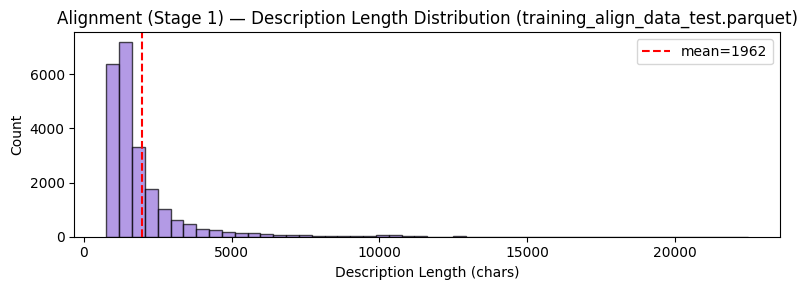


 SID Prediction (Stage 2)
  (Not generated yet — run the corresponding generate_*.py script first)

 Reasoning Activation (Stage 3)
  (Not generated yet — run the corresponding generate_*.py script first)



In [ ]:
## ============================================================
## Parquet training data files (generated by data/generate_*.py scripts)
##
## 1) training_align_data_{train,val,test}.parquet
##    - Script: generate_training_data.py
##    - Columns: user_id, description (text with SID + title + categories)
##    - Purpose: Stage 1 Itemic Alignment — teaches the LLM to map SID tokens to item text
##    - Split: train removes last 2 items, val removes last 1, test uses full sequence
##
## 2) training_prediction_sid_data_{train,val,test}.parquet
##    - Script: generate_sid_prediction_data.py
##    - Columns: user_id, description (SID-only sequence), groundtruth (target SID)
##    - Purpose: Stage 2 Recommendation — model predicts next SID from historical SID sequence
##
## 3) training_RA_{train,val,test}.parquet
##    - Script: generate_RA_data.py
##    - Columns: user_id, description (SID + title + categories), groundtruth, title, categories
##    - Purpose: Stage 3 Reasoning Activation — trains the model to reason before recommending (CoT)
## ============================================================
import os, glob

parquet_groups = {
    "Alignment (Stage 1)": sorted(glob.glob("data/training_align_data_*.parquet")),
    "SID Prediction (Stage 2)": sorted(glob.glob("data/training_prediction_sid_data_*.parquet")),
    "Reasoning Activation (Stage 3)": sorted(glob.glob("data/training_RA_*.parquet")),
}

for group_name, files in parquet_groups.items():
    print(f"{'=' * 60}")
    print(f" {group_name}")
    print(f"{'=' * 60}")
    if not files:
        print("  (Not generated yet — run the corresponding generate_*.py script first)\n")
        continue

    for fpath in files:
        df = pd.read_parquet(fpath)
        split_name = os.path.basename(fpath)
        print(f"\n  {split_name}")
        print(f"     Rows: {len(df):,}  |  Columns: {list(df.columns)}")

        # Show first row sample (truncate long text)
        row = df.iloc[0]
        for col in df.columns:
            val = str(row[col])
            display_val = val[:120] + "..." if len(val) > 120 else val
            print(f"     {col}: {display_val}")

    # Summarize split sizes
    split_sizes = {os.path.basename(f): len(pd.read_parquet(f)) for f in files}
    print(f"\n  Split sizes: {split_sizes}")

    # Visualize: description text length distribution (using the first file)
    df_first = pd.read_parquet(files[0])
    if "description" in df_first.columns:
        desc_lens = df_first["description"].str.len()
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.hist(desc_lens, bins=50, edgecolor="black", alpha=0.7, color="mediumpurple")
        ax.set_xlabel("Description Length (chars)")
        ax.set_ylabel("Count")
        ax.set_title(f"{group_name} — Description Length Distribution ({os.path.basename(files[0])})")
        ax.axvline(desc_lens.mean(), color="red", linestyle="--", label=f"mean={desc_lens.mean():.0f}")
        ax.legend()
        plt.tight_layout()
        plt.show()
    print()

#### Implicit CoT Injection
+ CoT Baselines in [./ImpCoT](./ImpCoT/)
+ Usage: Modify the `--impcot_mode` arg in the [training script](train/scripts/train_beauty_sid_rec.py)

### Next Steps (By 2/18/2026)

+ Implement CoT + GR for the teacher model
    - Tansfer the codebase to $R^2$ec